In [1]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip

--2017-11-05 03:29:12--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>]   5.64M  38.3KB/s    in 56s     

2017-11-05 03:30:11 (104 KB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None)
movies_df.head()

/home/salman/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None)
ratings_df.head()

/home/salman/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [6]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
len(movies_df)

3883

In [9]:
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [10]:
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [11]:
merged_df = movies_df.merge(ratings_df, on='MovieID')
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [12]:
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [13]:
amountOfUsedUsers = 1000
trX = []
for userID, curUser in userGroup:
    temp = [0] * len(movies_df)
    for num, movie in curUser.iterrows():
        temp[movie['List Index']] = movie['Rating'] / 5.0
    trX.append(temp)
    
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [14]:
hiddenUnits = 20
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits])
hb = tf.placeholder("float", [hiddenUnits])
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [15]:
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [16]:
alpha = 1.0

w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [17]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [18]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
cur_vb = np.zeros([visibleUnits], np.float32)
cur_hb = np.zeros([hiddenUnits], np.float32)
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
prv_vb = np.zeros([visibleUnits], np.float32)
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.123875
0.0828666
0.068386
0.0607019
0.0536339
0.0476225
0.0452854
0.0435397
0.043001
0.0423946
0.0417119
0.0414067
0.0407849
0.040324
0.0400262


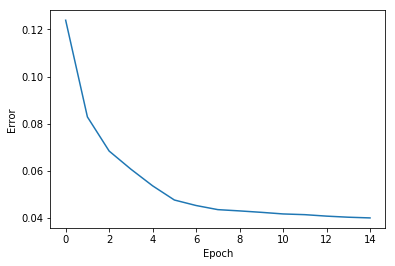

In [19]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print errors[-1]
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [20]:
inputUser = [trX[75]]

In [22]:
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [27]:
scored_movies_df_75 = movies_df
scored_movies_df_75["Recommendation Score"] = rec[0]
scored_movies_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.703232
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.542990
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.527287
523,527,Schindler's List (1993),Drama|War,523,0.523510
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.501410
2928,2997,Being John Malkovich (1999),Comedy,2928,0.483945
1245,1265,Groundhog Day (1993),Comedy|Romance,1245,0.431266
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.423078
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.365922
352,356,Forrest Gump (1994),Comedy|Romance|War,352,0.347875


In [23]:
merged_df.iloc[75]

MovieID         1
List Index      0
UserID        215
Rating          4
Name: 75, dtype: int64

In [24]:
movies_df_75 = merged_df[merged_df['UserID']==215]
movies_df_75.head()

,MovieID,List Index,UserID,Rating
75,1,0,215,4
11873,24,23,215,5
67543,260,257,215,5
82782,316,313,215,4
97063,356,352,215,5


In [28]:
merged_df_75 = scored_movies_df_75.merge(movies_df_75, on='MovieID', how='outer')
merged_df_75 = merged_df_75.drop('List Index_y', axis=1).drop('UserID', axis=1)

In [29]:
merged_df_75.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.703232,NaN
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.542990,NaN
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.527287,NaN
523,527,Schindler's List (1993),Drama|War,523,0.523510,NaN
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.501410,NaN
2928,2997,Being John Malkovich (1999),Comedy,2928,0.483945,NaN
1245,1265,Groundhog Day (1993),Comedy|Romance,1245,0.431266,NaN
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.423078,NaN
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.365922,NaN
352,356,Forrest Gump (1994),Comedy|Romance|War,352,0.347875,5.0
